In [1]:
!pip3 install torch-scatter==latest+cu101 torch-sparse==latest+cu101 torch-cluster==latest+cu101 torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0/torch_spline_conv-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4
  Found existing installation: torch-sparse 0.6.1
    Uninstalling torch-sparse-0.6.1:
      Successfully uninstalled torch-sparse-0.6.1
  Found existing installation: torch-cluster 1.5.4
    Unin

In [2]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

sys.path.append(os.path.abspath('./drive/My Drive/Skoltech_ML/project/m5_accuracy'))
os.chdir(os.path.abspath('./drive/My Drive/Skoltech_ML/project/m5_accuracy'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
sns.set_style('whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import torch
import time
import os
import pickle
from scipy import sparse

class Graph:
    def __init__(self, categories=['state_id', 'store_id', 'cat_id', 'dept_id'], flag_load=False, load_path='graph_data/'):
        self.cats = categories
        self.flag_load = flag_load
        self.load_path = load_path

    def __call__(self, df):
        graph = self.create_graph(df)
        return graph
        
    def create_graph(self, df):
        if self.flag_load:
            path = self.load_path + 'graph_dict.pickle'
            with open(path, 'rb') as handle:
                graph_dct, self.group_num, self.group_card = pickle.load(handle)
        else:
            df_ind = df.reset_index()
            groups_lst = df_ind.groupby(by=self.cats)['index'].apply(list).values
            graph_dct = {}
            
            self.group_card = [] # number of products i each group
            self.group_num = len(groups_lst)
            
            for gr_num, group in enumerate(tqdm(groups_lst)):
                
                for i, number in enumerate(group):
                    temp = np.delete(group, i, axis=0)
                    graph_dct[number] = temp
                    
                self.group_card.append(i)
            
            if not os.path.exists(self.load_path):
                os.makedirs(self.load_path)

            path = self.load_path + 'graph_dict.pickle'
            with open(path, 'wb') as handle:
                pickle.dump((graph_dct, self.group_num, self.group_card), handle)

        return graph_dct
    
    def one_hot(self, ind, card):
        card = card * (card + 1) # A_n^2 combinations of 2 edges
        one_hot_vector = np.concatenate((np.zeros(ind), [1], np.zeros(self.group_num-ind-1)), axis=0)
        sample = np.tile(list(one_hot_vector), (card, 1))

        return list(sample)
    
    def torch_format(self, df):
        graph = self.create_graph(df)
        if self.flag_load:
            path = self.load_path + 'attributes.pickle'
            with open(path, 'rb') as handle:
                self.edge_index, self.edge_attr = pickle.load(handle)
                self.edge_attr = self.edge_attr.todense()
        else:
            edge_index = [[key, value] for key in graph.keys() for value in graph[key]]
            # important: no need to reverse edge_index due to graph construction

            edge_index = torch.tensor(edge_index, dtype=torch.long)
            self.edge_index=edge_index.t().contiguous()
            
            edge_attr = np.array([]).reshape(0, self.group_num)
            for ind, card in enumerate(tqdm(self.group_card)):
                edge_attr = np.vstack((edge_attr, self.one_hot(ind, card)))
                
            self.edge_attr =  torch.tensor(edge_attr)

            path = self.load_path + 'attributes.pickle'
            with open(path, 'wb') as handle:
                pickle.dump((self.edge_index, sparse.csr_matrix(self.edge_attr)), handle)

        print(np.shape(self.edge_index))
        print(np.shape(self.edge_attr))

# start = time.time()
# graph_class = Graph(flag_load=False, load_path='/content/drive/My Drive/Skoltech_ML/project/m5_accuracy/data/')
# graph_class.torch_format(sales)
# print(time.time()-start)

In [0]:
class ETGConv(MessagePassing):
    '''
        Explicit temporal graph convolution
    '''

    def __init__(self, n_channels, n_relations):
        super(ETGConv, self).__init__(aggr='add')
        self.activation = nn.LeakyReLU(negative_slope=0.2)
        self.linear = nn.Linear(n_relations, 1)

    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, n_channels]
        # edge_index has shape [2, E]

        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv = 1 / deg
        norm = deg_inv[col]
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              edge_attr=edge_attr,
                              norm=norm)

    def message(self, x_i, x_j, edge_attr, norm):
        # x_i, x_j have shape [E, n_channels]

        phi = self.activation(self.linear(edge_attr))
        return norm.unsqueeze(-1) * (phi * (torch.sum(x_i * x_j, 1).unsqueeze(-1) * x_j))

    def update(self, aggr_out):
        # aggr_out has shape [N, n_channels]
        
        return aggr_out

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_hidden, n_relations, n_linear):
        super(Net, self).__init__()
        self.conv = ETGConv(n_hidden, n_relations)
        # self.bn1 = nn.BatchNorm1d(param_in_linear + hidden_state_size)
        # self.linear1 = nn.Linear(param_in_linear + hidden_state_size, param_in_linear + hidden_state_size)
        # self.bn2 = nn.BatchNorm1d(param_in_linear + hidden_state_size)
        # self.linear2 = nn.Linear(param_in_linear + hidden_state_size, param_in_linear + hidden_state_size)
        self.bn3 = nn.BatchNorm1d(n_linear + n_hidden)
        self.linear3 = nn.Linear(n_linear + n_hidden, 1)


    def forward(self, data):
        seq_emb, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        rel_emb = self.conv(seq_emb, edge_index, edge_attr)
        emb = torch.cat((seq_emb, rel_emb), -1)
        x = F.relu(emb)
        x = self.bn3(emb)
        x = self.linear3(x)
        # x = F.relu(emb)
        # x = self.bn2(x)
        # x = self.linear2(x)
        # x = F.relu(emb)
        # x = self.bn3(x)
        # x = self.linear3(x)
        return F.relu(x)

In [0]:
# Dataloader for GCN
def get_gcn_dataloader(embedding, ground_truth, edge_index, edge_attr, batch_size):
    dataset = [
               Data(x=torch.tensor(embedding[i], dtype=torch.float32),
                    y=torch.tensor(ground_truth[i], dtype=torch.float32),
                    edge_index=torch.tensor(edge_index, dtype=torch.int64),
                    edge_attr=torch.tensor(edge_attr, dtype=torch.float32)
                    ) for i in range(len(embedding))]
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [0]:
# Train GCN

def train_gcn(dataloader_train, dataloader_validation, net,
              epochs, lr=1e-3, device='cpu', verbose=True,
              verbose_freq=0.1):
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)

    verbose_step = max(2, int(epochs * verbose_freq))

    total_loss_train = 0
    n_batches_train = 0 
    criterion = nn.MSELoss().to(device)
    for epoch in range(epochs):
        # train
        net.train()
        for data in dataloader_train:
            optimizer.zero_grad()

            data = data.to(device)
            y = data.y
            prediction = net(data)

            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()
            n_batches_train += 1

        # verbose
        if epoch % verbose_step != 0 or not verbose:
            continue
        total_loss_val = 0
        n_batches_val = 0
        net.eval()
        with torch.no_grad():
            for data in dataloader_validation:
                data = data.to(device)
                y = data.y
                prediction = net(data)
                loss = F.mse_loss(prediction, y)
                total_loss_val += loss.item()
                n_batches_val += 1
        avg_loss_val = total_loss_val / n_batches_val
        avg_loss_train = total_loss_train / n_batches_train
        total_loss_train = 0
        n_batches_train = 0
        print(f'Epoch {epoch + 1}/{epochs} | validation loss = {avg_loss_val} | training loss = {avg_loss_train}')

In [0]:
sales_train = pd.read_csv('data/sales_train_validation.csv')
sales = sales_train.iloc[:, :6]

In [12]:
graph = Graph(flag_load=True, load_path='data/')
graph.torch_format(sales)

torch.Size([2, 16228460])
(16228460, 70)


In [0]:
with open('data/lstm_hidden_states.pickle', 'rb') as input_file:
    embeddings = pickle.load(input_file)

In [0]:
with open('data/lstm_hidden_states_val.pickle', 'rb') as input_file:
    embeddings_val = pickle.load(input_file)

In [18]:
embeddings_val.shape

(28, 30490, 16)

In [23]:
# Generate test data

print('Initial parameters')
T = 2000
N = 1000
U = 16
K = 10
p = 0.001

# Create a test graph
print('Create a graph')
test_edge_index = [[], []]
test_edge_attr = []
for i in range(N):
    for j in range(i + 1, N):
        edge_flag = np.random.uniform(low=0, high=1) < p
        if edge_flag:
            test_edge_index[0].append(i)
            test_edge_index[1].append(j)
            test_edge_index[0].append(j)
            test_edge_index[1].append(i)
            relation = np.random.choice([0, 1], size=K, replace=True, p=[1-1 / K / 2, 1 / K / 2])
            relation[np.random.randint(low=0, high=K)] = 1
            test_edge_attr.append(relation)
            test_edge_attr.append(relation.copy())

print('Number of edges:', len(test_edge_attr), len(test_edge_index[0]))
print('Number of attributes', len(test_edge_attr[0]))

Initial parameters
Create a graph
Number of edges: 1030 1030
Number of attributes 10


In [24]:
# Create a data
# Curve parameters a1*sin(1*2pi*w*t)+a2*sin(2*2pi*w*t)+a3*sin(3*2pi*w*t)+b*t+c
print('Create internal parameters')
bounds = {
          'a1': [-10, 10],
          'a2': [-10, 10],
          'a3': [-10, 10],
          'w': [1/T, 20 / T],
          'b': [-0.01, 0.01],
          'c': [-10, 10]
}

params = {
    k: np.random.uniform(low=v[0], high=v[1], size=(N, U)) for k, v in bounds.items()
}

# Introduce similarity
print('Introduce similarity')
s = 0.2
for x in enumerate(zip(test_edge_index[0][::2], test_edge_index[1][::2])):
    n, pair = x
    pos = n * 2
    i, j = pair
    for k, param in params.items():
        v = np.random.uniform(low=0.01, high=s)
        params[k][j] = (1 - v ** np.sum(test_edge_attr[pos])) * params[k][i]
        # print(param[j] / param[i])

print('Create an embedding')
days = np.arange(0, T, 1, dtype=np.int)
test_embedding = np.array(
    [(
      params['a1'] * np.sin(1 * 2 * np.pi * params['w'] * d) +
      params['a2'] * np.sin(2 * 2 * np.pi * params['w'] * d) +
      params['a3'] * np.sin(3 * 2 * np.pi * params['w'] * d) +
      params['b'] * d +
      params['c']
    ) for d in days]
)

print('Create a ground truth')
mean_params = {
    k: np.expand_dims(np.mean(p, axis=1), 1) for k, p in params.items() 
}
# test_ground_truth = np.array(
#     [(
#       mean_params['a1'] * np.sin(1 * 2 * np.pi * mean_params['w'] * d) +
#       mean_params['a2'] * np.sin(2 * 2 * np.pi * mean_params['w'] * d) +
#       mean_params['a3'] * np.sin(3 * 2 * np.pi * mean_params['w'] * d) +
#       mean_params['b'] * d +
#       mean_params['c']
#     ) for d in days]
# )
test_ground_truth = np.expand_dims(np.mean(test_embedding, axis=-1), 2)

Create internal parameters
Introduce similarity
Create an embedding
Create a ground truth


In [25]:
test_ground_truth.shape

(2000, 1000, 1)

Embeddings (random): 205 303


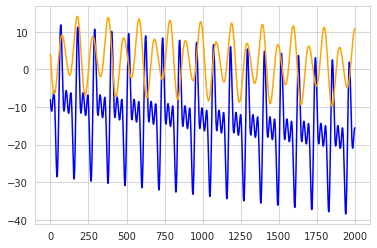

In [26]:
i1, i2 = np.random.randint(0, high=N, size=2)
print('Embeddings (random):', i1, i2)
plt.plot(days, test_embedding[:, i1, 3], color='blue')
plt.plot(days, test_embedding[:, i2, 3], color='orange')

Embeddings (random): 686 580


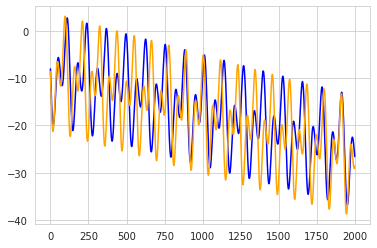

In [27]:
n_edges = len(test_edge_attr)
edge = np.random.randint(0, high=n_edges)
i1, i2 = test_edge_index[0][edge], test_edge_index[1][edge]
print('Embeddings (random):', i1, i2)
plt.plot(days, test_embedding[:, i1, 3], color='blue')
plt.plot(days, test_embedding[:, i2, 3], color='orange')

In [0]:
test_embedding_train = test_embedding[:-200]
test_ground_truth_train = test_ground_truth[:-200]
test_embedding_test = test_embedding[-200:]
test_ground_truth_test = test_ground_truth[-200:]

In [0]:
dataloader_train = get_gcn_dataloader(test_embedding_train, test_ground_truth_train, test_edge_index, test_edge_attr, 128)
dataloader_test = get_gcn_dataloader(test_embedding_test, test_ground_truth_test, test_edge_index, test_edge_attr, 128)

In [0]:
net = Net(U, K, U)

In [32]:
train_gcn(dataloader_train, dataloader_test, net, 5, lr=0.01)

Epoch 1/5 | validation loss = 6.730219841003418 | training loss = 5.855066108703613
Epoch 3/5 | validation loss = 1.5338153839111328 | training loss = 2.0575517813364663
Epoch 5/5 | validation loss = 0.2685888558626175 | training loss = 0.4801374187072118


In [0]:
net.eval()
pred = []
with torch.no_grad():
    for i in range(len(test_embedding_test)):
        x = test_embedding_test[i]
        y = test_ground_truth_test[i]
        data = Data(x=torch.tensor(x, dtype=torch.float32),
                    y=torch.tensor(y, dtype=torch.float32),
                    edge_index=torch.tensor(test_edge_index, dtype=torch.int64),
                    edge_attr=torch.tensor(test_edge_attr, dtype=torch.float32)
                    )
        pred.append(net(data).numpy())
pred = np.array(pred)

In [34]:
print('Prediction shape:', pred.shape)
print('Ground truth shape:', test_ground_truth_test.shape)

Prediction shape: (200, 1000, 1)
Ground truth shape: (200, 1000, 1)


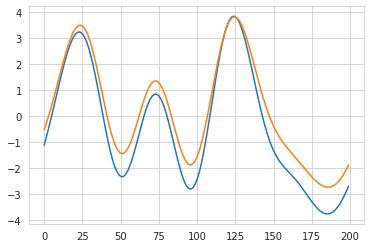

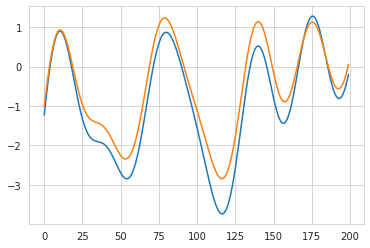

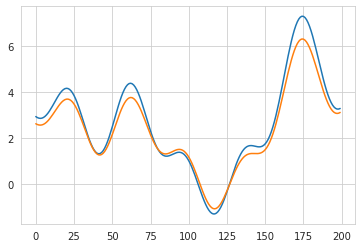

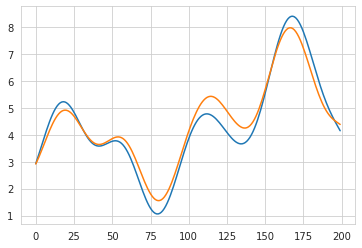

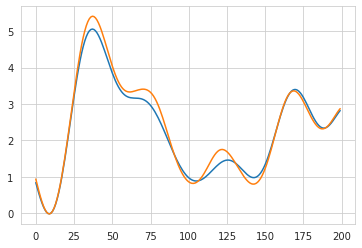

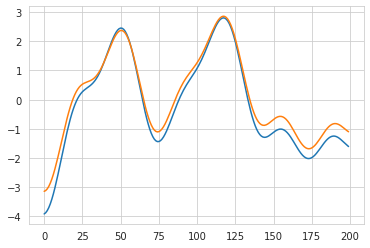

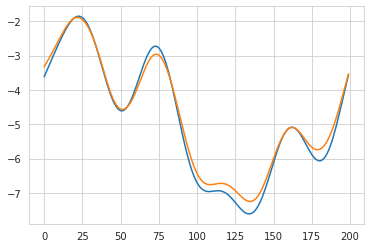

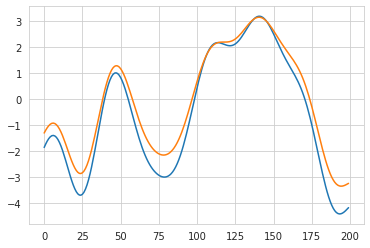

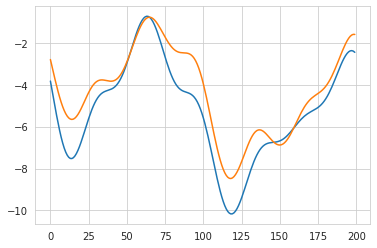

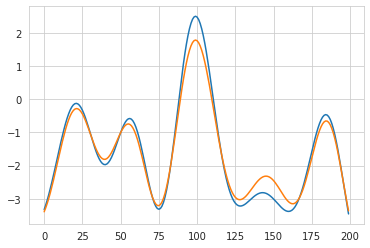

In [35]:
for i in range(10):
    idx = np.random.randint(low=0, high=N)
    plt.plot(test_ground_truth_test[:, idx, 0])
    plt.plot(pred[:, idx, 0])
    plt.show()

In [169]:
n = len(test_embedding_test)
n = 1
tgc = ETGConv(U, K)
for i in range(n):
        x = test_embedding_test[i]
        y = test_ground_truth_test[i]
        data = Data(x=torch.tensor(x, dtype=torch.float32),
                    y=torch.tensor(y, dtype=torch.float32),
                    edge_index=torch.tensor(test_edge_index, dtype=torch.int64),
                    edge_attr=torch.tensor(test_edge_attr, dtype=torch.float32)
                    )
        output = tgc(data.x, data.edge_index, data.edge_attr)
        print(output.size())

torch.Size([1000, 16])
